In [2260]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
import math

In [2261]:
Home_room=pd.read_excel("/Users/ashutoshgupta/Development/Projects/Vizuara/Home room teachers.xlsx")
Period_allotment=pd.read_excel("/Users/ashutoshgupta/Development/Projects/Vizuara/Period allotment.xlsx")
Teachers=pd.read_excel("/Users/ashutoshgupta/Development/Projects/Vizuara/Teachers Availability.xlsx")


In [2262]:
Teachers.columns=Teachers.columns.str.strip()

In [2263]:

def Home_room_cleaning(df):
  # Drop columns where all values are None or NaN
  df = df.drop(columns=df.columns[df.isna().all()])
  # Drop rows where all values are None or NaN
  df=df.dropna(how="all")
  # Filling all missing spaces with the most repeated character of each column
  for i in df.columns[df.isna().any()]:
    df[i].fillna(df[i].mode()[0],inplace=True)
  return df


In [2264]:
def Period_table_cleaning(n):
    return n.replace(0,np.nan)
Period_allotment=Period_table_cleaning(Period_allotment)

In [2265]:

Class=input("Enter the Class: ")
Division=input("Enter the Section: ")
class_name=f"{Class} {Division}"
no_of_days=5
Days=["Monday","Tuesday","Wednesday","Thursday","Friday"]

#Constraints
Break=[("Jr. KG",["12:45 PM","1:15 PM"]),("Sr. KG",["12:45 PM","1:15 PM"]),("I",["9:25 AM","9:45 AM"]),("I",["12:45 PM","1:15 PM"])]
Demand=["Tuesday",["10:45 AM"],"Assembly"]
Timing={"Jr. KG":["10:15 AM","2:15 PM"],"Sr. KG":["10:15 AM","2:15 PM"],"I":["8:15 AM","2:15 PM"]}

In [2266]:
Home_room=Home_room_cleaning(Home_room)
Home_room["Classes"]=Home_room["Classes"].str.strip()
search_row = np.array(Home_room[Home_room["Classes"] == class_name].iloc[:,0:2])

In [2267]:
def subject_teacher(Teachers):
    teachers = Teachers.loc[:, ["Subject", class_name]]
    def modify(x):
        if isinstance(x, str):
            return x.split(",")
    teachers[class_name]=teachers[class_name].apply(modify)
    teachers=np.array(teachers)
    return teachers

teachers=subject_teacher(Teachers)

In [2268]:

subject_occurance=np.array(Period_allotment[["Subject",Class]])
for i in range(len(subject_occurance)):
    if subject_occurance[i][0] == "Assembly":
        subject_occurance[i][1] = 1

In [2269]:
def time_coder(time):
  return dt.strptime(dt.strptime(time,"%I:%M %p").strftime("%H:%M"),"%H:%M")

def time_decoder(time):
  return dt.strptime(time.strftime("%I:%M"),"%H:%M").time()

In [2270]:
# Timings
School_start=Timing[Class][0]
School_end=Timing[Class][1]

School_start=time_coder(School_start)
School_end=time_coder(School_end)

# Duration
Duration=30

Breaks=[]
def no_of_breaks(Break):
    c=0
    for i in Break:
        if i[0]==Class:
            Breaks.append(dt.strptime(i[1][0], "%H:%M %p"))
            c+=1
    return c

no_of_breaks=no_of_breaks(Break)


def no_of_periods(School_start,School_end,Duration):   
    total_time=(School_end-School_start).total_seconds()/60
    return int(total_time/Duration)

no_of_periods=no_of_periods(School_start, School_end, Duration)

def least_duration(Break):
    difference=[]
    for i in Break:
        if i[0]==Class:
            x,y=i[1]
            difference.append(int((time_coder(y)-time_coder(x)).total_seconds()/60))
    new=[x for x in difference if x<Duration]
    return new[0] if new else Duration

# This function generates time for each period
def Time_Generator(School_start,no_of_periods):
    least=least_duration(Break)

    if Class=="Jr. KG" or Class=="Sr. KG":
        no_of_periods=no_of_periods-1
    else:
        no_of_periods=no_of_periods-2

    
    n=[School_start]
    for i in range(no_of_periods):
        if least<Duration:
                less=Duration-least
                x=School_start+timedelta(minutes=less)
                n.append(x)
                School_start=x
                least=Duration  # For adding Home Room period

        for j in Break:
            if j[0]==Class:
                a,b=j[1]
                if time_coder(a)==School_start:
                    x=time_coder(b)
                    n.append(x)
                    School_start=time_coder(b) # For adding Breaks


        x=School_start+timedelta(minutes=30)
        n.append(x)
        School_start=x
    new=[]
    for i in range(len(n)-1):
        new.append([str(time_decoder(n[i])),str(time_decoder(n[i+1]))])
    return new

Time=Time_Generator(School_start,no_of_periods)
no_of_periods=len(Time)
print(Time)

[['08:15:00', '08:25:00'], ['08:25:00', '08:55:00'], ['08:55:00', '09:25:00'], ['09:25:00', '09:45:00'], ['09:45:00', '10:15:00'], ['10:15:00', '10:45:00'], ['10:45:00', '11:15:00'], ['11:15:00', '11:45:00'], ['11:45:00', '12:15:00'], ['12:15:00', '12:45:00'], ['12:45:00', '01:15:00'], ['01:15:00', '01:45:00'], ['01:45:00', '02:15:00']]


In [2271]:
def subject_generator(subject_occurance):
    new_list=[]
    list_1=[]
    list_2=[]
    for i in subject_occurance:
        if isinstance(i[1], int) and isinstance(i[0], str):
            x,y=i
            for i in range(y):
                list_1.append(x)
        elif isinstance(i[1], float) and isinstance(i[0], str) and not pd.isna(i[1]):
            x,y=i
            for i in range(math.ceil(y)):
                list_2.append(x)
    new_list=new_list+list_1

    n=[]
    for i in range(0,len(list_2)-1,2):
        if list_2[i]==list_2[i+1]:
            n.append(list_2[i])
        else:
            n.append(list_2[i]+'/'+list_2[i+1])
    list_2=n
    new_list=new_list+list_2

    list_3=[]
    for i in range(no_of_days*no_of_breaks):
        list_3.append("Break")
    new_list=new_list+list_3

    list_4=[]
    for i in range((no_of_periods*no_of_days)-len(new_list)):
        list_4.append("HR")
    new_list=new_list+list_4

    return new_list

In [2272]:
def time_difference(times):
    time1 = dt.strptime(times[0], '%H:%M:%S')
    time2 = dt.strptime(times[1], '%H:%M:%S')
    return int((time2-time1).total_seconds()/60)  

In [2273]:

def generate_periods(new_list, Demand, Time, Breaks, Days, no_of_days, no_of_periods):
    Periods = []
    for i in range(no_of_days):
        Subjects = []
        for j in range(no_of_periods):
            x, y = dt.strptime(Demand[1][0], "%I:%M %p"), dt.strptime(Time[j][0], "%H:%M:%S")
            if y in Breaks:
                Subjects.append("Break")
                new_list.remove("Break")
            elif Demand[0] == Days[i] and x == y:
                if Demand[2] in new_list:
                    Subjects.append(Demand[2])
                    new_list.remove(Demand[2])
            elif time_difference(Time[j])==10:
                if "HR" in new_list:
                    Subjects.append("HR")
                    new_list.remove("HR")
            else:
                available_subjects = [s for s in new_list if s != "Break" and s != "Assembly" and s != "HR"]
                if available_subjects:
                    sub = np.random.choice(available_subjects)
                    Subjects.append(sub)
                    new_list.remove(sub)
        Periods.append(Subjects)
    return Periods

In [2274]:

def generate_day_teacher(Periods, teachers):
    Day_teacher = []
    for x in Periods:
        Teacher_period = []
        for y in x:
            found_teacher = False
            split_value = y.split('/')
            if split_value:
                random_choice = np.random.choice(split_value)
                for z in teachers:
                    if y == z[0] and z[1] is not None:
                        Teacher_period.append(z[1][0])
                        found_teacher = True
                        break
                    elif len(split_value) == 2 and random_choice == z[0] and z[1] is not None:
                        Teacher_period.append(z[1][0])
                        found_teacher = True
                        break
            if not found_teacher:
                Teacher_period.append("HR")
        Day_teacher.append(Teacher_period)
    return Day_teacher

In [2275]:
def generate_final_teachers(Day_teacher, search_row):
    Final_Teachers = []
    split_name = ''
    for i in search_row:
        x, y = i
        split_name = y.split(',')
    for i in Day_teacher:
        Semi_Teacher = []
        for j in i:
            if j == "HR":
                Semi_Teacher.append(np.random.choice(split_name))
            else:
                Semi_Teacher.append(j)
        Final_Teachers.append(Semi_Teacher)
    return Final_Teachers

In [2276]:
def Period_Time_span():
    Period_Time_span=[]
    c=1
    for i in Time:
        match_found = False
        for j in Break: 
            if j[0]==Class and str(time_coder(j[1][0]))==f"1900-01-01 {i[0]}":
                Period_Time_span.append(f'{i[0]}-{i[1]}')
                match_found = True
                Break
        if not match_found:
            Period_Time_span.append(f'Period {c} {i[0]}-{i[1]}')  
            c+=1      
    return Period_Time_span

In [2277]:
def final_data():
    final_data = []
    new_list = subject_generator(subject_occurance)
    Periods = generate_periods(new_list, Demand, Time, Breaks, Days, no_of_days, no_of_periods)
    Day_teacher = generate_day_teacher(Periods, teachers)
    Final_Teachers = generate_final_teachers(Day_teacher, search_row)
    for i, j in zip(Periods, Final_Teachers):
        subject_and_teacher = []
        for x, y in zip(i, j):
            subject_and_teacher.append(f'{x} "{y}"')
        final_data.append(subject_and_teacher)
    return final_data

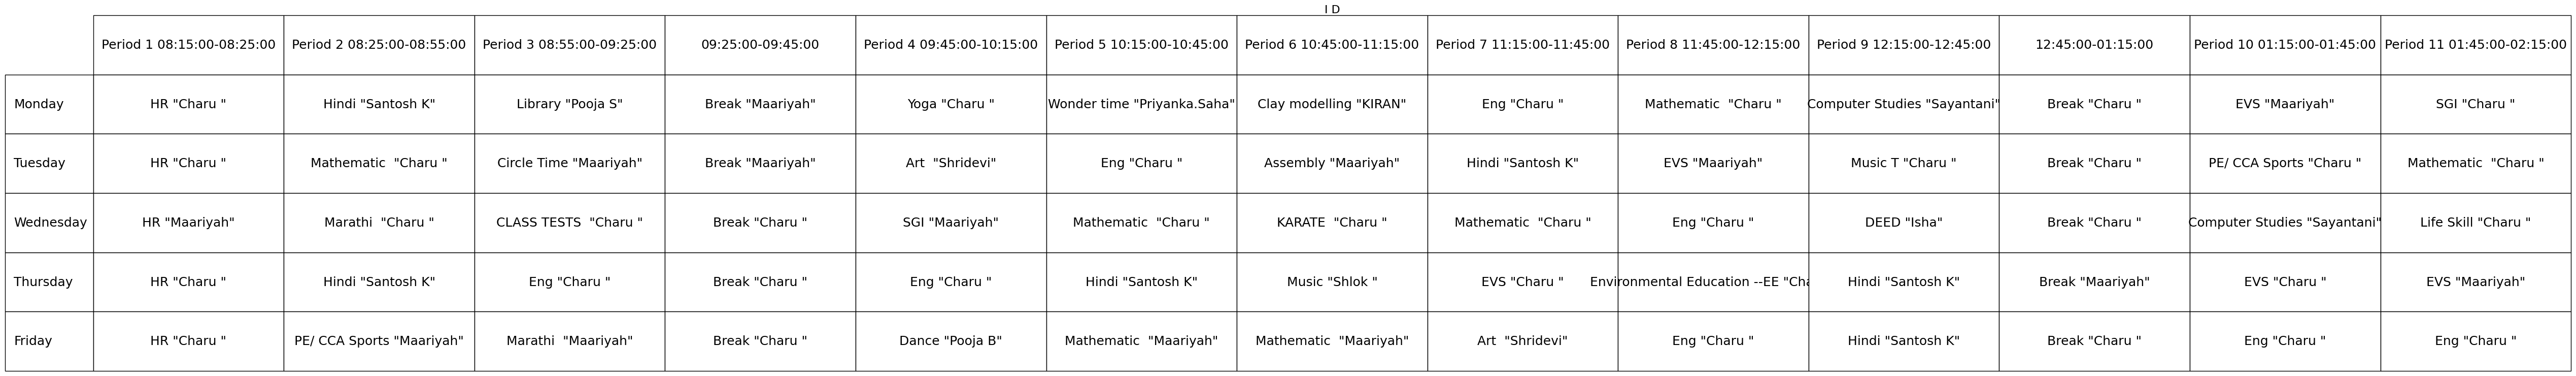

In [2278]:
def display(data):
    fig, ax = plt.subplots(figsize=(9,9))
    ax.axis('tight')
    ax.axis('off')
    ax.set_title(class_name,fontsize=16,loc="center")
    table = ax.table(
        cellText=data,
        rowLabels=Days, 
        colLabels=Period_Time_span(), 
        loc='center', 
        cellLoc='center' 
    )
    table.auto_set_font_size(False)
    table.set_fontsize(18)
    table.scale(7, 7)
    plt.show()

display(final_data())